# Evaluations

Every extraction task needs a good way to evaluate whether the extracted data is correct and give it a score of how correct it is. The goal is to quantify the extraction pipeline's (model's) performance. With partial scores giving insight on how correct a data point is, usually between 0 and 1, the pipeline can be improved by fixing any edge cases or errors found by comparing lower scored data points.

### Imports
We import all required libraries at the start here.

In [1]:
import json
from statistics import mean
from pint import UnitRegistry

### Simple example data

To start of with a simple example, we define a set of key-value pairs as our ground truth and a dummy output from the model as prediction.

In [2]:
truth = {
    "text": "result",
    "correct": "correct",
    "number": 0.45,
    "wrong": 1.023,
    "bool": False,
    "missing": 0,
}
prediction = {
    "text": "result",
    "correct": "incorrect",
    "number": 0.45,
    "wrong": 1.025,
    "bull": False,
}

### Scoring a Key-Value pair

To properly evaluate a structured output from a model, we have to walk through the structure of the ground truth and the output simultaneously. We have to check every value we were expecting the model to return and count how many of these are correct.
With the count of the correct keys, we can calculate our metrics:


$$
\mathrm{precision} = \frac{|{\text{relevant entries}} \cap {\text{retrieved entries}}| }{|{\text{retrieved entries}}|}
$$

$$
\mathrm{recall} = \frac{|{\text{relevant entries}} \cap {\text{retrieved entries}}| }{|{\text{relevant entries}}|}
$$

$$
F_1 = \frac{2}{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}}
$$

In [3]:
relevant_entries_intersection_retrieved_entries = []
for t_key in truth:
    if t_key in prediction:
        if truth[t_key] == prediction[t_key]:
            relevant_entries_intersection_retrieved_entries.append(t_key)
recall = len(relevant_entries_intersection_retrieved_entries) / len(truth.keys())
precision = len(relevant_entries_intersection_retrieved_entries) / len(
    prediction.keys()
)
print(f"Recall: {recall:.2f}\nPrecision: {precision:.2f}")

Recall: 0.33
Precision: 0.40


## Evaluation of results from the choosing a learning paradigm chapter

Using those scores, we can now revisit the results from our previous experiments in the [Choosing a learning paradigm chapter](choosing-paradigm-openai-results).

### Loading the results
We will use the responses from GPT-4o. We will read the JSON file that has both the predicted structured output and the expected reference ground truth.

In [4]:
with open("../finetune/OpenAI_results.json", "r") as f:
    open_ai_results = json.load(f)
    truths = open_ai_results["1-shot"]["references"]
    predictions = open_ai_results["1-shot"]["predictions"]
    # We convert the output from a JSON str to a dict object
    truths = [json.loads(truth) for truth in truths]
    predictions = [
        json.loads(prediction[prediction.index("{") : prediction.rindex("}") + 1])
        for prediction in predictions
    ]

### Defining common functions for later use

In [5]:
def common_items(dict1, dict2):
    """Finds common keys between two dicts and yields if the values are equal."""
    for key in dict1:
        if key in dict2:
            if isinstance(dict1[key], dict) and isinstance(dict2[key], dict):
                for subkey, subvalue in common_items(dict1[key], dict2[key]):
                    yield f"{key}.{subkey}", subvalue
            elif isinstance(dict1[key], list) and isinstance(dict2[key], list):
                for item1 in dict1[key]:
                    for item2 in dict2[key]:
                        if isinstance(item1, dict) and isinstance(item2, dict):
                            for subkey, subvalue in common_items(item1, item2):
                                yield f"{key}.[].{subkey}", subvalue
            elif dict1[key] == dict2[key]:
                yield key, dict1[key]


def count_correct_items(dict1, dict2):
    """Counts the common keys between two dicts and returns the count."""
    return len([correct for correct in common_items(dict1, dict2)])


def count_leaf_keys(d):
    """Counts the number of keys at the deepest levels (leaf) of an arbitrarily nested dict"""
    if isinstance(d, dict):
        count = 0
        for value in d.values():
            count += count_leaf_keys(value)
        return count
    elif isinstance(d, list):
        count = 0
        for item in d:
            count += count_leaf_keys(item)
        return count
    else:
        return 1

### Evaluation of the results

```{warning}

The code below assumes that the `truths` and `predictions` are already matched. 
If you run extraction using a model, this is not the case in general. 

In this case, you will need to match the ground truth with the prediction.
This is explained in a section below.
```

In [6]:
recalls = []
precisions = []
for i, truth in enumerate(truths):
    prediction = predictions[i]
    num_correct_items = count_correct_items(truth, prediction)
    recalls.append(num_correct_items / count_leaf_keys(truth))
    precisions.append(num_correct_items / count_leaf_keys(prediction))

recall = mean(recalls)
precision = mean(precisions)
print(f"Recall: {recall:.2f}\nPrecision: {precision:.2f}")

Recall: 0.30
Precision: 0.30


```{note}
The variable `truth` is the manually curated reference extraction and `prediction` is what the LLM returns through the pipeline.
```

#### F1 score

In [7]:
f1_score = 2 / ((1 / recall) + (1 / precision))
print(f"F1 score: {f1_score:.2f}")

F1 score: 0.30


`````{admonition} LLM-as-Judge
:class: tip
For certain applications, it is possible to use an LLM as the evaluator, which is probably one of the easiest ways to implement some evaluations. However, as {cite:t}`shankar2024validatesvalidatorsaligningllmassisted` states, the evaluator model have all the problems of the LLM used for extraction, so it is not always the best approach, and to have a good evaluation, it is necessary to [align the LLM-as-Judge with the preferences of a human evaluator](https://hamel.dev/blog/posts/llm-judge/#step-5-build-your-llm-as-a-judge-iteratively).
`````

### Matching to ground truth

If we look at the inputs section of our data, we realize that the evaluation of the extraction can be more complex than one might expect: 

- First, we have to deal with the fact that some values are chemicals. This is problematic as there are typically many equivalent ways of naming the same chemical. In naive socring this will lead to problems. 
For instance, our ground truth might contain "aspirin" but we extracted "2-acetoxybenzoic acid" (the IUPAC name). A string matching would not identify those two names to be the same -- even though they refer to the same chemical.

- If we extract data, there might be multiple entries that are almost the same. In addition, the model might miss extracting some entries or hallucinate some. For our evaluations, we must decide what to compare (i.e., which extracted entry to compare with which entry from the ground truth). 
This requires us to *match* the extracted entry with the ground truth entry.

The code above assumed that `truths` and `predictions` are the same length and already such that each item `i` in `truths` matches to item `i` in `predictions`. 
As we just described, this is not the case in general, and we have to find the closet extraction for a given element of `truths` to perform a meaningful evaluation. 

In the following, we will do this based on the `inputs` section of the data. As a first approximation, we will say that a ground truth "matches" an extraction result if it is the most similar from all extraction results. To solve this for all the elements of the extraction, we use the `deepdiff` library to measure how similar two dictionaries are, and then use the [Kuhn-Munkres algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) to find the optimal assignments between ground truth and extraction.

Note that in practice it is often better to not perform the matching on the entire extracted output but only on what one can define as an "identifier" of an entry. 

`````{admonition} On what to match
:class: note

The choice of what fields of the schema the matching is performed on is crucial.
If one imagines extracting reactions with associated yields one could imagine matching reactions based on the reaction yield.

This, however, is not the ideal way to match reactions as the interpretation of the results is counterintuitive: Chemists would intuitively match extracted results and ground truth based on the reaction SMILES (and conditions) and then compare the yields. If now the matching is performed on the yield, the evaluation would be counterintuitive to a chemist. For example, and incorrectly extracted  yield might lead to counterintuitive matches and thus a bad evaluation.
```


For materials, this can be properties that might be a canonicalized representation of the material. For reactions, this might be the canonicalized reaction SMILES with condition information.

```{admonition} The DeepDiff algorithm
:class: note dropdown
The [Deep Distance concept in DeepDiff](https://zepworks.com/deepdiff/current/deep_distance.html) is inspired by [Levenshtein Edit Distance](https://en.wikipedia.org/wiki/Levenshtein_distance), but it's not the same. 

The Levenshtein distance is a metric used to measure the difference between two sequences (usually strings). 
It's defined as the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word into another. 
For example, the Levenshtein distance between "kitten" and "sitting" is 3, as it takes three edits to transform one into the other.
DeepDiff's Deep Distance differs from Levenshtein distance in a few key ways:

- It works on any Python objects, not just strings.
- It's based on the number of operations needed to convert one object to another, not necessarily the minimum number.
- The result is normalized to a value between 0 and 1.
- The calculation is highly dependent on the granularity of the diff results, which can be controlled by parameters passed to DeepDiff. One element of the granularity is, for example, how the algorithm deals with the comparison of iterables such as list (e.g., if the order is ignored or not).
```

```{admonition} The Kuhn-Munkres algorithm 
:class: note dropdown

The [Kuhn-Munkres algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) is used to solve the assignment problem, which is about finding the optimal way to assign $n$ items to $n$ other items (e.g., tasks to workers) in a way that minimizes the total cost or maximizes the total profit.
Key points about the Kuhn-Munkres algorithm:

- Purpose: It finds a perfect matching in a weighted bipartite graph that minimizes the total weight of the matching.
- Input: A cost matrix where each element represents the cost of assigning one item to another.
- Output: An optimal assignment that minimizes the total cost.
- Time Complexity: $\mathcal{O}(n^3)$, where $n$ is the number of vertices in one partition of the bipartite graph.
- Optimality: It guarantees finding the optimal solution.

### Process:
Imagine you're planning a party game where you need to pair up kids with party hats. Each kid has a preference score for each hat, and you want to make everyone as happy as possible.
Here's how the Hungarian algorithm would solve this:

1. Setup:

    Make a grid (matrix) where rows are kids and columns are hats.
    Each cell has a "sadness score" - how sad a kid would be wearing that hat (lower is better).


2. Find the Cheapest Hats:

    For each kid, find their favorite hat (lowest sadness score).
    Write down how sad they'd be with that hat.


3. Try Matching:

    Try to give each kid their favorite hat.
    If every kid gets a unique hat, you're done! If not, move to step 4.


4. Detective Work:

    Start with a kid who didn't get a hat.
    Look for a path to swap hats so this kid gets one:

    Can they take someone else's favorite hat?
    Can that someone take another hat they like?
    Keep going until you find an unused hat.


    If you find such a path, do the swaps and go back to step 3.
    If not, move to step 5.


5. Adjust Expectations:

    If you can't find a swapping path, slightly increase everyone's sadness tolerance.
    This makes more hat options available.
    Go back to step 4 and try again.


6. Repeat:

    Keep doing steps 4 and 5 until everyone has a hat.


In programming language: 

- The "sadness scores" form the cost matrix.
- The "favorite hats" step is creating initial feasible labeling.
- The "swapping path" is an augmenting path in graph theory.
- "Adjusting expectations" is the label update step.
- The algorithm always finds the optimal solution in polynomial time ($\mathcal{O}(n^3)$).

You'd implement this with matrices and graph algorithms.
Use data structures like priority queues for efficiency.
The core loop involves depth-first search (for augmenting paths) and matrix operations.

This algorithm is powerful because it always finds the best overall matching, not just good individual matches. 
```

In [8]:
from deepdiff import DeepDiff

recalls = []
precisions = []

# Here we use a 2d matrix to store the distance between each ground truth and prediction
# as distance, we use DeepDiff to calculate the distance
scores = []
for i, truth in enumerate(truths):
    scores_ = []
    for prediction in predictions:
        scores_.append(
            DeepDiff(
                truth,
                prediction,
                ignore_order=True,
                get_deep_distance=True,
                ignore_numeric_type_changes=True,
                cache_size=5000,
                cutoff_intersection_for_pairs=1,
            )["deep_distance"]
        )

    scores.append(scores_)

The scores matrix is a 2d matrix of size (`len(truths)`, `len(predictions)`) and tells us how similar each truth is to each prediction.

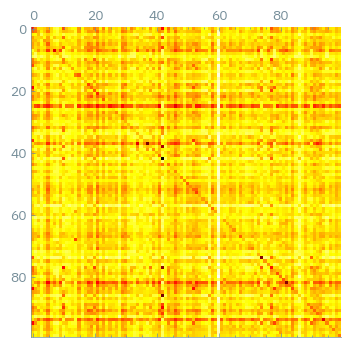

In [9]:
import matplotlib.pyplot as plt


plt.matshow(scores, cmap="hot", interpolation="nearest")

If the items were perfectly matched, we would get a diagonal matrix.

In [10]:
from munkres import Munkres

m = Munkres()  # We will use the Kuhn-Munkres algorithm for our matching
indexes = m.compute(scores)  # We find the best matching scores for each key

The indices returned by the Kuhn-Munkres algorithm tell us the best assignment ground truth and prediction.

In [11]:
indexes

[(0, 91),
 (1, 1),
 (2, 2),
 (3, 60),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 77),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 66),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 0),
 (20, 20),
 (21, 21),
 (22, 19),
 (23, 23),
 (24, 68),
 (25, 25),
 (26, 47),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 24),
 (33, 33),
 (34, 38),
 (35, 35),
 (36, 52),
 (37, 37),
 (38, 34),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 36),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 84),
 (53, 53),
 (54, 54),
 (55, 55),
 (56, 56),
 (57, 57),
 (58, 58),
 (59, 59),
 (60, 3),
 (61, 61),
 (62, 22),
 (63, 63),
 (64, 64),
 (65, 65),
 (66, 72),
 (67, 67),
 (68, 14),
 (69, 69),
 (70, 70),
 (71, 71),
 (72, 93),
 (73, 73),
 (74, 74),
 (75, 75),
 (76, 76),
 (77, 10),
 (78, 32),
 (79, 79),
 (80, 80),
 (81, 81),
 (82, 82),
 (83, 83),
 (84, 78),
 (85, 85),
 (86, 86),
 (87, 98),
 (88, 88),
 (89, 89),
 (90, 90),
 (91, 62),
 (92, 92

With those, we can now recompute the recall and precision.

In [12]:
# Once we have the indexes of the matches, we collect the pairs in one list object
recalls = []
precisions = []

for i, j in indexes:
    truth = truths[i]
    prediction = predictions[j]

    num_correct_items = count_correct_items(truth, prediction)
    recalls.append(num_correct_items / count_leaf_keys(truth))
    precisions.append(num_correct_items / count_leaf_keys(prediction))

recall = mean(recalls)
precision = mean(precisions)
print(f"Recall: {recall:.2f}\nPrecision: {precision:.2f}")

Recall: 0.31
Precision: 0.30


### Data normalization

Sometimes the data you have in the ground truth could be normalized to a certain format. For example, all units could be converted to SI units. The original text might have them in different units. In such a situation, it is essential to convert the prediction from the model to our required units before checking those keys.

Let's take a **truth** and **prediction** consisting of values and units:

In [13]:
truth = {"mass": {"value": 22.0, "unit": "g"}}

prediction = {"mass": {"value": 22000.0, "unit": "mg"}}

Now, we can parse the prediction with **pint** and normalize the values to SI units.

In [14]:
ureg = UnitRegistry()
text_representation_of_value = (
    str(prediction["mass"]["value"]) + " " + prediction["mass"]["unit"]
)
print("Converting", text_representation_of_value)
normalized_pint_quantity = ureg(text_representation_of_value).to("g")
print("to", normalized_pint_quantity)

Converting 22000.0 mg
to 22.0 gram


Now we can check the magnitudes of our truth value and our normalized predicted value.

In [15]:
if truth["mass"]["value"] == normalized_pint_quantity.magnitude:
    print("Predicted value is correct.")

Predicted value is correct.


#### Chemically informed normalization

When we extract chemical or materials science data, the entities can often be representation in many equivalent forms. 
To address this, one most normalized the representations prior to performing any evaluation.


##### Organics
When we are trying to extract chemical formulas (as the reagents in our example), they could be reported in various forms. 
To make sure we got the expected value regardless of what form it's represented in, we can convert them to their SMILES representation. This is important to make sure we have the right information and not score incorrectly.

Here, we set up example extractions from a model and show how to get their SMILES before validation. Note that this is essential because a string distance (that we used above) between common names and SMILES would make no sense. Here we must normalize the entries before we can compute any meaningful score.

In [16]:
from matextract.utils import name_to_smiles
from rdkit import Chem


def canonical_smiles(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))


truth = {"solvents": ["CCCO", "CC(C)O", "CC(C)=O", "CC(=O)O", "C=O"]}

prediction = {"solvents": ["propanol", "isopropanol", "Propanone", "Ethanoic acid"]}

predictions_as_smiles = {
    "solvents": [name_to_smiles(solvent) for solvent in prediction["solvents"]]
}

truth_canonical = [canonical_smiles(solvent) for solvent in truth["solvents"]]
predictions_as_smiles_canonical = [
    canonical_smiles(solvent) for solvent in predictions_as_smiles["solvents"]
]


number_of_values_correct = set(truth_canonical) & set(predictions_as_smiles_canonical)

number_of_values_correct = len(number_of_values_correct)

precision = number_of_values_correct / len(predictions_as_smiles["solvents"])
recall = number_of_values_correct / len(truth["solvents"])
print(f"Recall: {recall:.2f}\nPrecision: {precision:.2f}")

/Users/kevinmaikjablonka/miniconda3/envs/dataextract2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Recall: 0.80
Precision: 1.00


##### Inorganics

Also for inorganic materials there is a need for normalization. For example, formulas might be reported in the Hill or IUPAC system, or just as a reduced empirical formula.

In [18]:
from pymatgen.core import Composition

truth = {"inorganics": ["SiC2", "CaCO3", "NaCN", "CO", "HCL"]}

prediction = {"inorganics": ["C2 Si", "C Ca O3", "Na1 C1 N1", "C1 O6"]}

predictions_as_reduced_formula = {
    "inorganics": [
        Composition(inorganic).reduced_formula for inorganic in prediction["inorganics"]
    ]
}

number_of_values_correct = len(
    [
        inorganic
        for inorganic in truth["inorganics"]
        if inorganic in predictions_as_reduced_formula["inorganics"]
    ]
)

precision = number_of_values_correct / len(predictions_as_reduced_formula["inorganics"])
recall = number_of_values_correct / len(truth["inorganics"])
print(f"Recall: {recall:.2f}\nPrecision: {precision:.2f}")

Recall: 0.60
Precision: 0.75
